In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holiday
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from time import time
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, LSTM
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

Read and Process Data

Columns
Date: The trading date.
Open: The opening price of Tesla's stock on the given date.
High: The highest price of the stock during the trading session.
Low: The lowest price of the stock during the trading session.
Close: The closing price of the stock on the given date.
Adj Close: The adjusted closing price of the stock, accounting for any corporate actions like stock splits and dividends.
Volume: The number of shares traded on the given date.

In [4]:
df = pd.read_csv("Tesla_dataset.csv",parse_dates=[0], index_col=0)
df.head(10)
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [5]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3505.000000,3505.000000,3505.000000,3505.000000,3505.000000,3.505000e+03
mean,73.941523,75.549608,72.209440,73.916853,73.916853,9.688131e+07
std,101.999877,104.246204,99.526282,101.916537,101.916537,7.897872e+07
min,1.076000,1.108667,0.998667,1.053333,1.053333,1.777500e+06
25%,11.345333,11.546667,11.010000,11.310667,11.310667,4.716300e+07
50%,17.302000,17.557333,16.969334,17.319332,17.319332,8.214300e+07
75%,146.919998,149.630005,142.833328,147.050003,147.050003,1.226595e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


In [9]:
df.shape

(3505, 6)

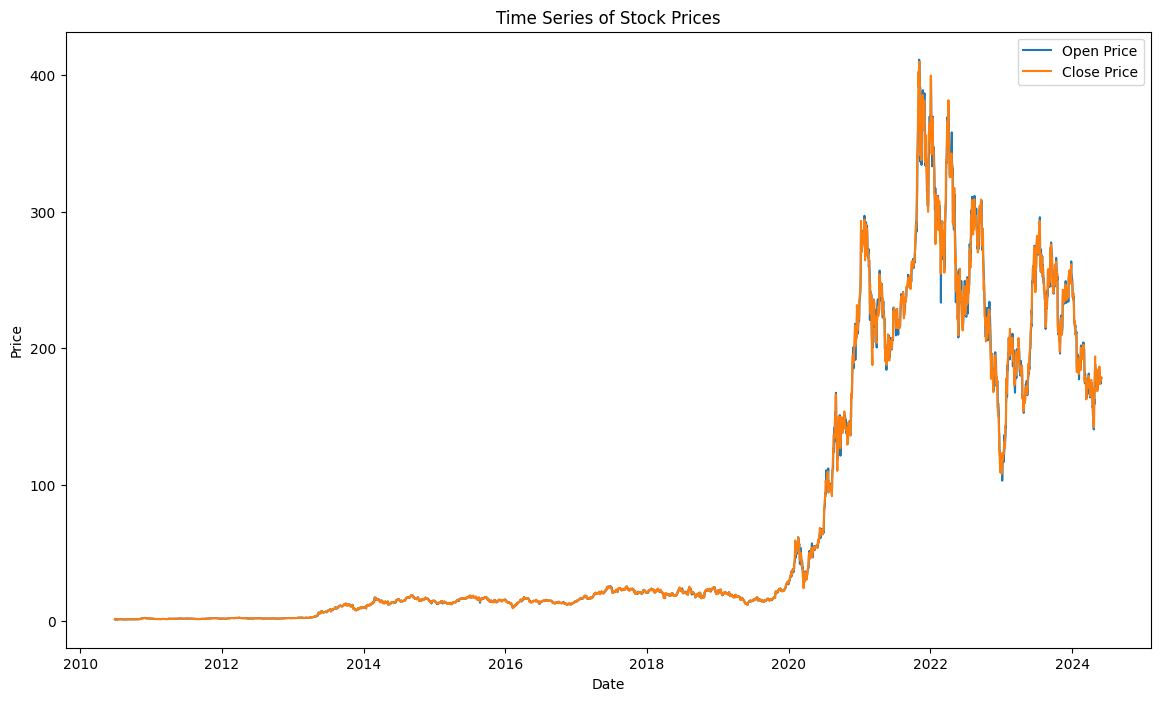

In [10]:

plt.figure(figsize=(14, 8))

plt.plot(df.index, df['Open'], label='Open Price')
plt.plot(df.index, df['Close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Time Series of Stock Prices')
plt.legend()  
plt.show()

In [11]:
fig = px.line(df, y=["High", "Low"], title="High and Low Prices")
fig.show()

Adding Month and Year Coloumns and limiting from 2021 onwards

In [12]:
df.index = pd.to_datetime(df.index, format = '%Y-%m-%d')
start_date = datetime(2021,1,1)
end_date = datetime(2024,5,31)
df = df.loc[start_date:end_date]
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,239.820007,248.163330,239.063339,243.256668,243.256668,145914600
2021-01-05,241.220001,246.946671,239.733337,245.036667,245.036667,96735600
2021-01-06,252.830002,258.000000,249.699997,251.993332,251.993332,134100000
2021-01-07,259.209991,272.329987,258.399994,272.013336,272.013336,154496700
2021-01-08,285.333344,294.829987,279.463318,293.339996,293.339996,225166500


SARIMA
(1−ϕ1​B)(1−Φ1​Bs)(1−B)(1−Bs)yt​=(1+θ1​B)(1+Θ1​Bs)εt
 


Focusing on Trend Period

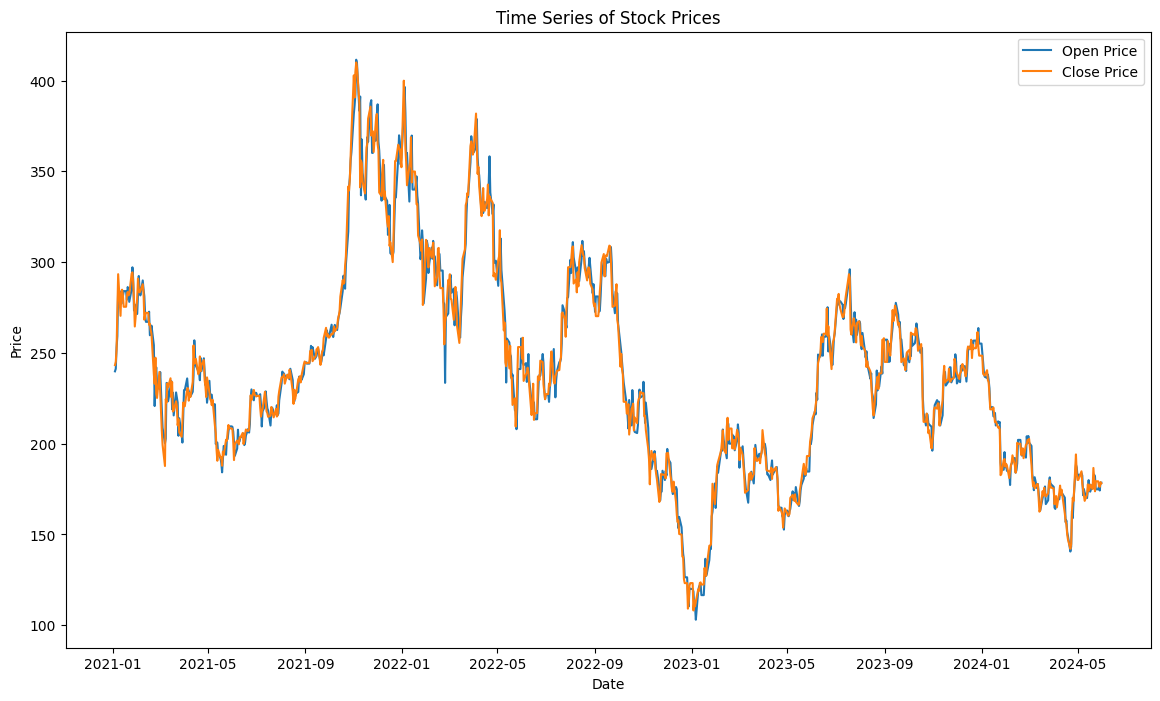

In [13]:
df = df.asfreq('B', method='pad')
df['Close'] = df['Close'].ffill()
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['Open'], label='Open Price')
plt.plot(df.index, df['Close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Time Series of Stock Prices')
plt.legend()

C:\Users\tejus\AppData\Local\Temp\ipykernel_4656\665014751.py:1: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



<Figure size 1400x800 with 0 Axes>

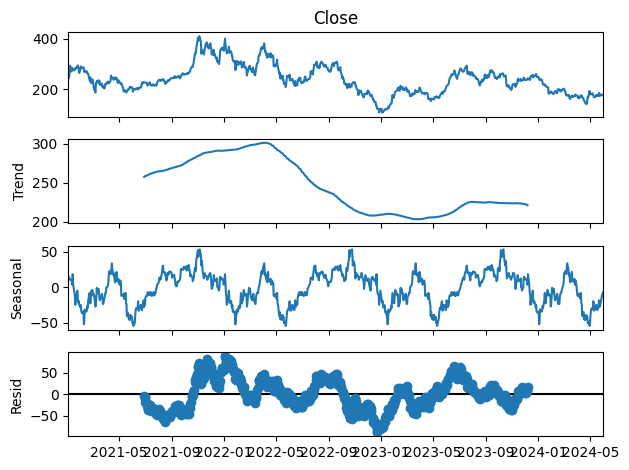

In [14]:
df['Close'] = df['Close'].fillna(method='ffill').fillna(method='bfill')
result = seasonal_decompose(df['Close'], model='additive', period=252)
plt.figure(figsize=(14, 8))
result.plot()
plt.show()

<Figure size 1400x800 with 0 Axes>

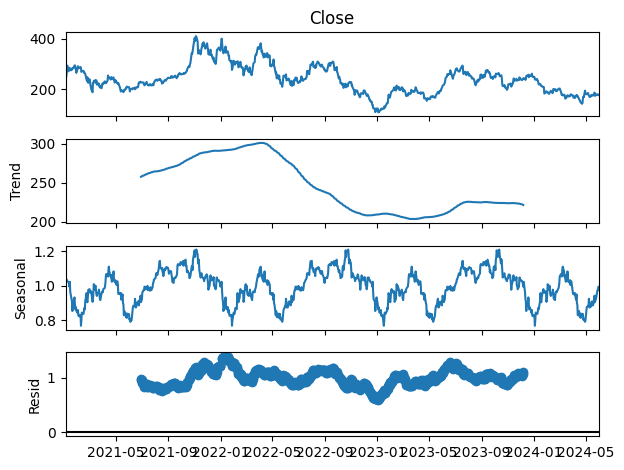

In [15]:
result = seasonal_decompose(df['Close'], model='multiplicative', period=252)
plt.figure(figsize=(14, 8))
result.plot()
plt.show()

What does this mean?

Close: Our Original Series/Metric
Appears to have some seasonality and a general upward trend until the second quarter of 2022.

Trend: Shows the overall direction of data without the fluctuations caused by seasonality.
Initally a good run in 2021-2022, gradually reduces after Q2 of 2022.

Seasonality: The cyclic patterns, shows repeating patterns for that year.
There is a noticeable cyclic pattern, with repeating fluctuations each year.

Residual: Other noise or remaining fluctuations after removing seasonality and trend.
It is relatively small and random, indicating there is not much external variation in the data.

ACF Plots

X-axis: Represents the time lag (in this case, periods, likely days).
Y-axis: Represents the correlation coefficient, ranging from -1 to 1.

High positive values: Indicate a strong positive correlation at that lag. This means that the value at a given point is likely to be similar to the value a certain number of periods before.

High negative values: Indicate a strong negative correlation. This means that the value at a given point is likely to be opposite to the value a certain number of periods before.

Values near zero: Indicate little or no correlation.

Blue shaded area: Represents the confidence interval. If a correlation falls outside this area, it's considered statistically significant.

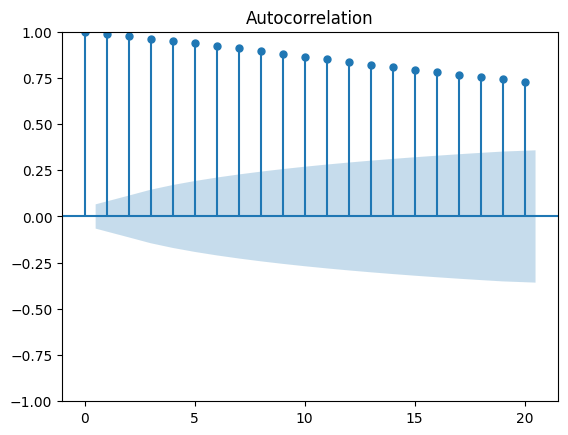

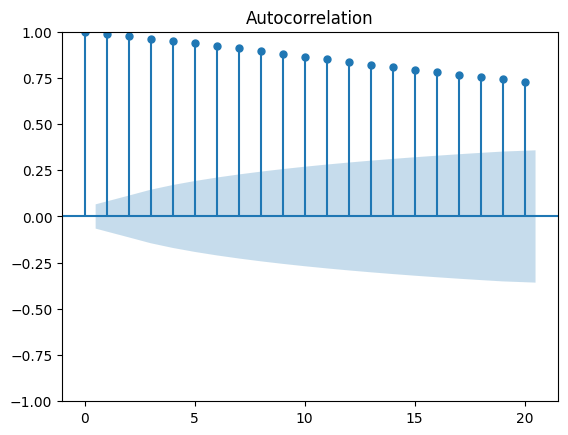

In [16]:
plot_acf(df['Close'],lags=20)

There's a strong positive correlation at lag 1, meaning the closing price today is highly correlated with the closing price yesterday.


The correlation decreases as the lag increases, suggesting that the influence of past values on the current value diminishes over time.

PCF PLOTS


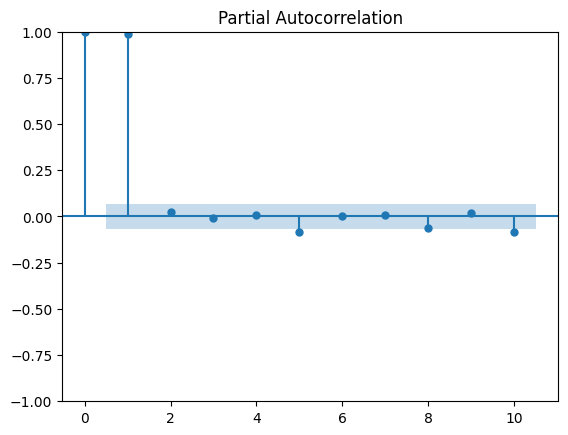

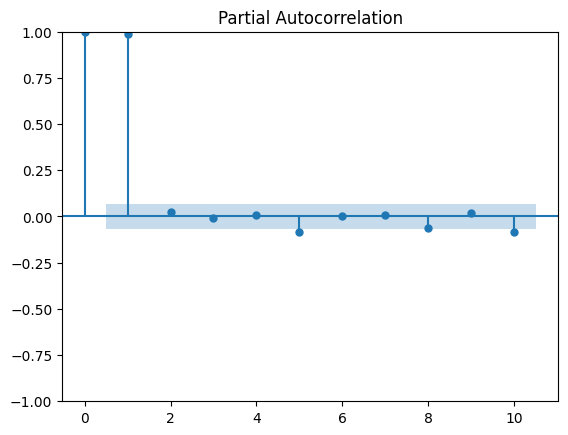

In [17]:
plot_pacf(df['Close'],lags=10)

Significant Lag: There is a significant spike at lag 1, indicating a strong direct relationship between the current value and the previous value.
No Significant Lags Beyond 1: After lag 1, the PACF values are close to zero and within the confidence interval, suggesting no significant correlation with past values beyond the immediate previous period.

In [18]:
arima = ARIMA(df['Close'],order=(2,1,1))
predictions = arima.fit().predict()

d:\timeseries\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

d:\timeseries\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



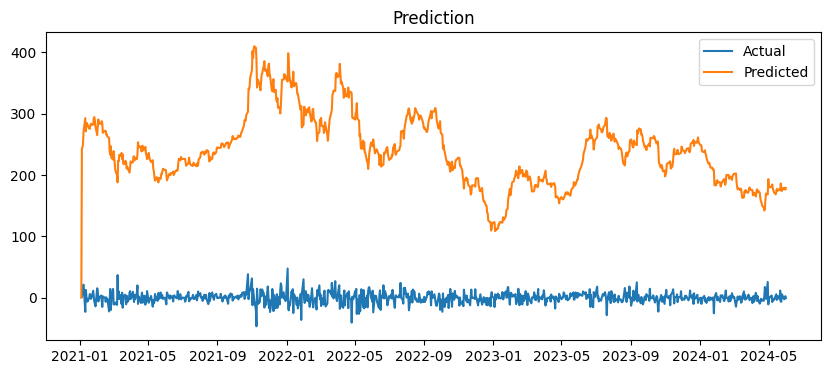

In [19]:

plt.figure(figsize=(10,4))
plt.plot(df['Close'].diff(), label = "Actual")
plt.plot(predictions,label = "Predicted")
plt.title("Prediction")
plt.legend()

In [20]:
sarima = SARIMAX(df['Close'],order=(1,1,1),seasonal_order=(1,1,0,2))
predictions = sarima.fit().predict()

In [21]:
#plt.figure(figsize=(16,4))
#plt.plot(df['Close'].diff(), label = "Actual")
#plt.plot(predictions,label = "Predicted")
#plt.title("Prediction")
#plt.legend()

In [22]:
df_diff = df['Close'].diff().dropna()


In [23]:
df_log = np.log(df['Close'])
df_log_diff = df_log.diff().dropna()

In [24]:
df_seasonal_diff = df['Close'].diff(periods=12).dropna()
rolling_mean = df['Close'].rolling(window=12).mean()
df_detrended = df['Close'] - rolling_mean
df_detrended.dropna(inplace=True)


In [25]:
from scipy.signal import detrend
df_detrended = detrend(df['Close'])

In [26]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_diff.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -14.20958671709141
p-value: 1.7308363729063596e-26


In [27]:
model = ARIMA(df_diff, order=(12, 0, 0))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  889
Model:                ARIMA(12, 0, 0)   Log Likelihood               -3194.061
Date:                Fri, 09 Aug 2024   AIC                           6416.122
Time:                        01:56:35   BIC                           6483.183
Sample:                    01-05-2021   HQIC                          6441.755
                         - 05-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0708      0.324     -0.219      0.827      -0.705       0.564
ar.L1         -0.0214      0.033     -0.645      0.519      -0.086       0.043
ar.L2         -0.0044      0.028     -0.158      0.8

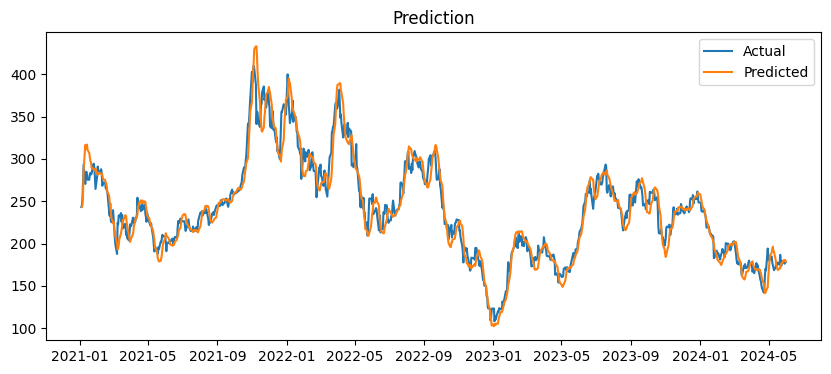

In [28]:
model = ARIMA(df_diff, order=(12, 2, 0))
model_fit = model.fit()
predictions_diff = model_fit.predict()
predictions = df['Close'].iloc[0] + predictions_diff.cumsum()
plt.figure(figsize=(10, 4))
plt.plot(df['Close'], label="Actual")
plt.plot(predictions, label="Predicted")
plt.title("Prediction")
plt.legend()
plt.show()

In [60]:
df['Close'] = df['Close'].shift(-1)
df = df.drop(df.index[-1])

In [61]:
x = df.drop('Close', axis = 1)
y = df['Close']


In [62]:
df=df.drop(['Adj Close'], axis=1)

KeyError: "['Adj Close'] not found in axis"

In [63]:
time_split = TimeSeriesSplit(n_splits=3)
for train, test in time_split.split(x):
    X_train,X_test = x[:len(train)], x[len(train) : (len(train) + len(test))]
    Y_train, Y_test = y[:len(train)].values.ravel(), y[len(train):(len(train)+len(test))].values.ravel()

In [64]:
X_train

,Open,High,Low,Volume
Date,,,,
2021-01-04,239.820007,248.163330,239.063339,145914600
2021-01-05,241.220001,246.946671,239.733337,96735600
2021-01-06,252.830002,258.000000,249.699997,134100000
2021-01-07,259.209991,272.329987,258.399994,154496700
2021-01-08,285.333344,294.829987,279.463318,225166500
...,...,...,...,...
2023-07-19,296.040009,299.290009,289.519989,142355400
2023-07-20,279.559998,280.929993,261.200012,175158300
2023-07-21,268.000000,268.000000,255.800003,161050100


In [65]:
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.fit_transform(X_test)
Y_train = scaler_Y.fit_transform(Y_train.reshape(-1,1))
Y_test = scaler_Y.fit_transform(Y_test.reshape(-1,1))


In [67]:
trainX = np.array(X_train)
testX = np.array(X_test)
timesteps = 4
features = trainX.shape[1] 
try:
    X_train = trainX.reshape((trainX.shape[0], timesteps, features))
    X_test = testX.reshape((testX.shape[0], timesteps, features))
except ValueError as e:
    print(f"Error in reshaping: {e}")


In [68]:
model=Sequential()
model.add(LSTM(128,return_sequences=True,input_shape=(1,features),activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(64,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

d:\timeseries\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [69]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 1, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
history = model.fit(X_train, Y_train,validation_data=(X_test,Y_test), epochs=250, batch_size=8, validation_split=0.2)

Epoch 1/250
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 2/250
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 3/250
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 4/250
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 5/250
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 6/250
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 7/250
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 8/250
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 9/250
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.002

In [72]:
pred = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [73]:
y_pred = scaler_Y.inverse_transform(pred)
y_real = scaler_Y.inverse_transform(Y_test)

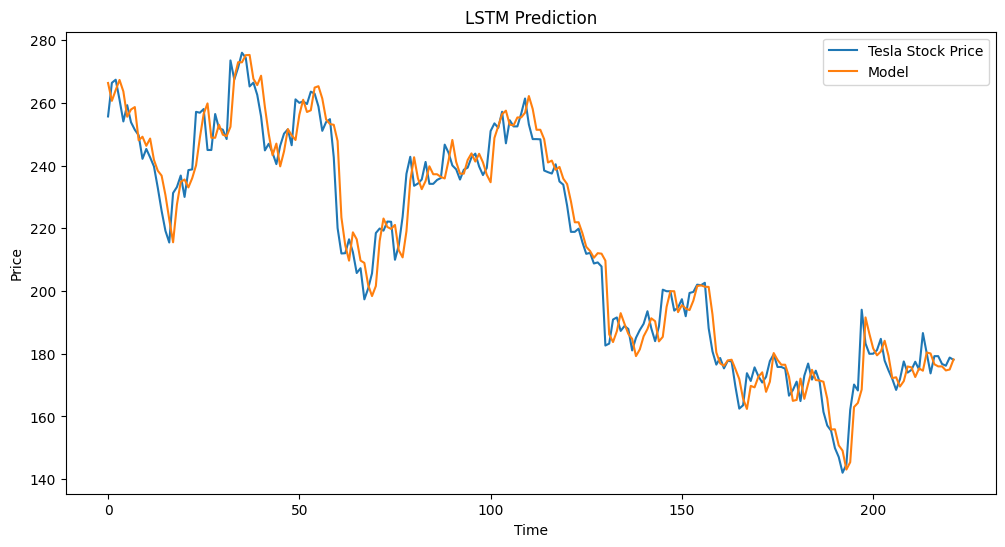

In [79]:
plt.figure(figsize=(12, 6))
plt.plot(y_real, label='Tesla Stock Price')
plt.plot(y_pred, label='Model')
plt.title('LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()